## The purpose of this exercise is to learn and practice machine learning standard process
- Use the most naive implementation
- Will use a few ways to do feature selection
- Model evaluation is only one step to familize the entire process of ML

In [89]:
# Import Libraries
import pandas as pd
import numpy as np
import zipfile
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomTreesEmbedding, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, precision_recall_curve, auc, make_scorer, average_precision_score, roc_auc_score
#from sklearn.compose import make_column_transformer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
# import training data=
root = Path(".")
with zipfile.ZipFile(root/"titanic.zip") as z:
    names = z.namelist()
    df_train = pd.read_csv(z.open(names[2]))
    x_df_test = pd.read_csv(z.open(names[1]))
    y_df_test = pd.read_csv(z.open(names[0]))
    y_df_test = y_df_test.drop(columns=['PassengerId'])
    
df_test = pd.concat([x_df_test, y_df_test],axis=1)
df_data = pd.concat([df_train, df_test], axis=0)


### Remove the unused variables

In [3]:
# drop the variables that varies too much --> not providing much information
drop_var = ['PassengerId', "Name", "Ticket", "Cabin"]
df_data = df_data.drop(drop_var, axis=1)

### Fill the missing variables

In [4]:
dict_fill_age = df_data.groupby("Sex")["Age"].mean().to_dict()

for gender, fill_age in dict_fill_age.items():
    df_data.loc[(df_data.Sex==gender) & (df_data.Age.isna()), "Age"] = fill_age


In [5]:
df_data.Fare = df_data.Fare.fillna(value=df_data.Fare.median())

In [6]:
SI = SimpleImputer(strategy="most_frequent")
df_data.Embarked = SI.fit_transform(df_data[['Embarked']])

### Encode the categorical variables to numeric variables

In [7]:
df_data["Sex_encoded"] = df_data.Sex.map({"male": 0, "female":1}).astype('int8')


In [8]:
label_encoder = LabelEncoder()
df_data["Embarked_encoded"] = label_encoder.fit_transform(df_data.Embarked).astype('int8')

### Feature selection and grid search

In [30]:
cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_encoded', 'Embarked_encoded']

scoring = {"recall": make_scorer(recall_score, greater_is_better=True),
           "precision": make_scorer(precision_score, greater_is_better=True),
           "accuracy": make_scorer(accuracy_score, greater_is_better=True),
           #'ROC_AUC': make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
           }

params = {'selector__direction': ['backward', 'forward'],
          'est__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'est__gamma': ['scale', 'auto', 1, 2, 3],
          'est__C': [i for i in range(1,11)]
       }

est = SVC(gamma=1, C=1, random_state=42, kernel='linear')
#est = SVR(gamma=1, C=1, kernel='linear')

rfe_selector = RFECV(est, cv=5, n_jobs=-1, step=1)
sfs_selector = SequentialFeatureSelector(est, cv=5, n_jobs=-1, n_features_to_select='auto', direction='backward')

sfs_backward_pipe = Pipeline(
                steps=[('scalar', StandardScaler()),
                       ('selector', sfs_selector),
                       ("est", SVC(gamma=1, C=1, random_state=42, kernel='linear'))]
                )

grid = GridSearchCV(
                     sfs_backward_pipe,
                     param_grid=params, 
                     scoring= scoring,
                     refit="accuracy",
                     return_train_score=True,
                     cv=3,
                     n_jobs=-1
                     )

                    

df_train = df_data.iloc[:df_train.shape[0],:]
df_test  = df_data.iloc[df_train.shape[0]:,:]

grid.fit(df_train[cols], df_train["Survived"])

df_grid = pd.DataFrame(grid.cv_results_)
#print(back_selector.get_support())
#print(back_selector.get_feature_names_out())


In [58]:
df_grid.param_est__gamma = df_grid.param_est__gamma.astype(str)

df_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_est__C,param_est__gamma,param_est__kernel,param_selector__direction,params,split0_test_recall,...,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,mean_train_accuracy,std_train_accuracy
0,4.307521,0.446858,0.016721,0.004711,1,scale,linear,backward,"{'est__C': 1, 'est__gamma': 'scale', 'est__ker...",0.701754,...,0.801347,0.771044,0.786756,0.012397,163,0.786195,0.787879,0.794613,0.789562,0.003637
1,4.039837,0.130641,0.018040,0.003227,1,scale,linear,forward,"{'est__C': 1, 'est__gamma': 'scale', 'est__ker...",0.701754,...,0.801347,0.771044,0.786756,0.012397,163,0.786195,0.779461,0.794613,0.786756,0.006198
2,3.572627,0.363447,0.019511,0.005230,1,scale,poly,backward,"{'est__C': 1, 'est__gamma': 'scale', 'est__ker...",0.692982,...,0.811448,0.771044,0.790123,0.016571,47,0.797980,0.792929,0.794613,0.795174,0.002100
3,3.198024,0.073292,0.032016,0.018150,1,scale,poly,forward,"{'est__C': 1, 'est__gamma': 'scale', 'est__ker...",0.429825,...,0.814815,0.784512,0.790123,0.018305,47,0.814815,0.799663,0.801347,0.805275,0.006781
4,3.367019,0.056658,0.038079,0.003669,1,scale,rbf,backward,"{'est__C': 1, 'est__gamma': 'scale', 'est__ker...",0.701754,...,0.808081,0.784512,0.794613,0.009912,9,0.796296,0.794613,0.799663,0.796857,0.002100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,162.300146,34.043595,0.031321,0.012737,10,3,poly,forward,"{'est__C': 10, 'est__gamma': 3, 'est__kernel':...",0.429825,...,0.814815,0.784512,0.790123,0.018305,47,0.813131,0.797980,0.801347,0.804153,0.006496
396,11.214680,0.399340,0.060580,0.001696,10,3,rbf,backward,"{'est__C': 10, 'est__gamma': 3, 'est__kernel':...",0.666667,...,0.801347,0.784512,0.777778,0.022503,281,0.836700,0.819865,0.824916,0.827160,0.007054
397,9.871092,1.312399,0.058674,0.004735,10,3,rbf,forward,"{'est__C': 10, 'est__gamma': 3, 'est__kernel':...",0.543860,...,0.828283,0.797980,0.789001,0.036298,149,0.860269,0.818182,0.836700,0.838384,0.017223
398,8.216236,0.214261,0.047510,0.009296,10,3,sigmoid,backward,"{'est__C': 10, 'est__gamma': 3, 'est__kernel':...",0.473684,...,0.680135,0.643098,0.641975,0.031625,396,0.668350,0.685185,0.651515,0.668350,0.013746


### Plot the graph based on the paramaters

<ipython-input-137-fb30dea222b7>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


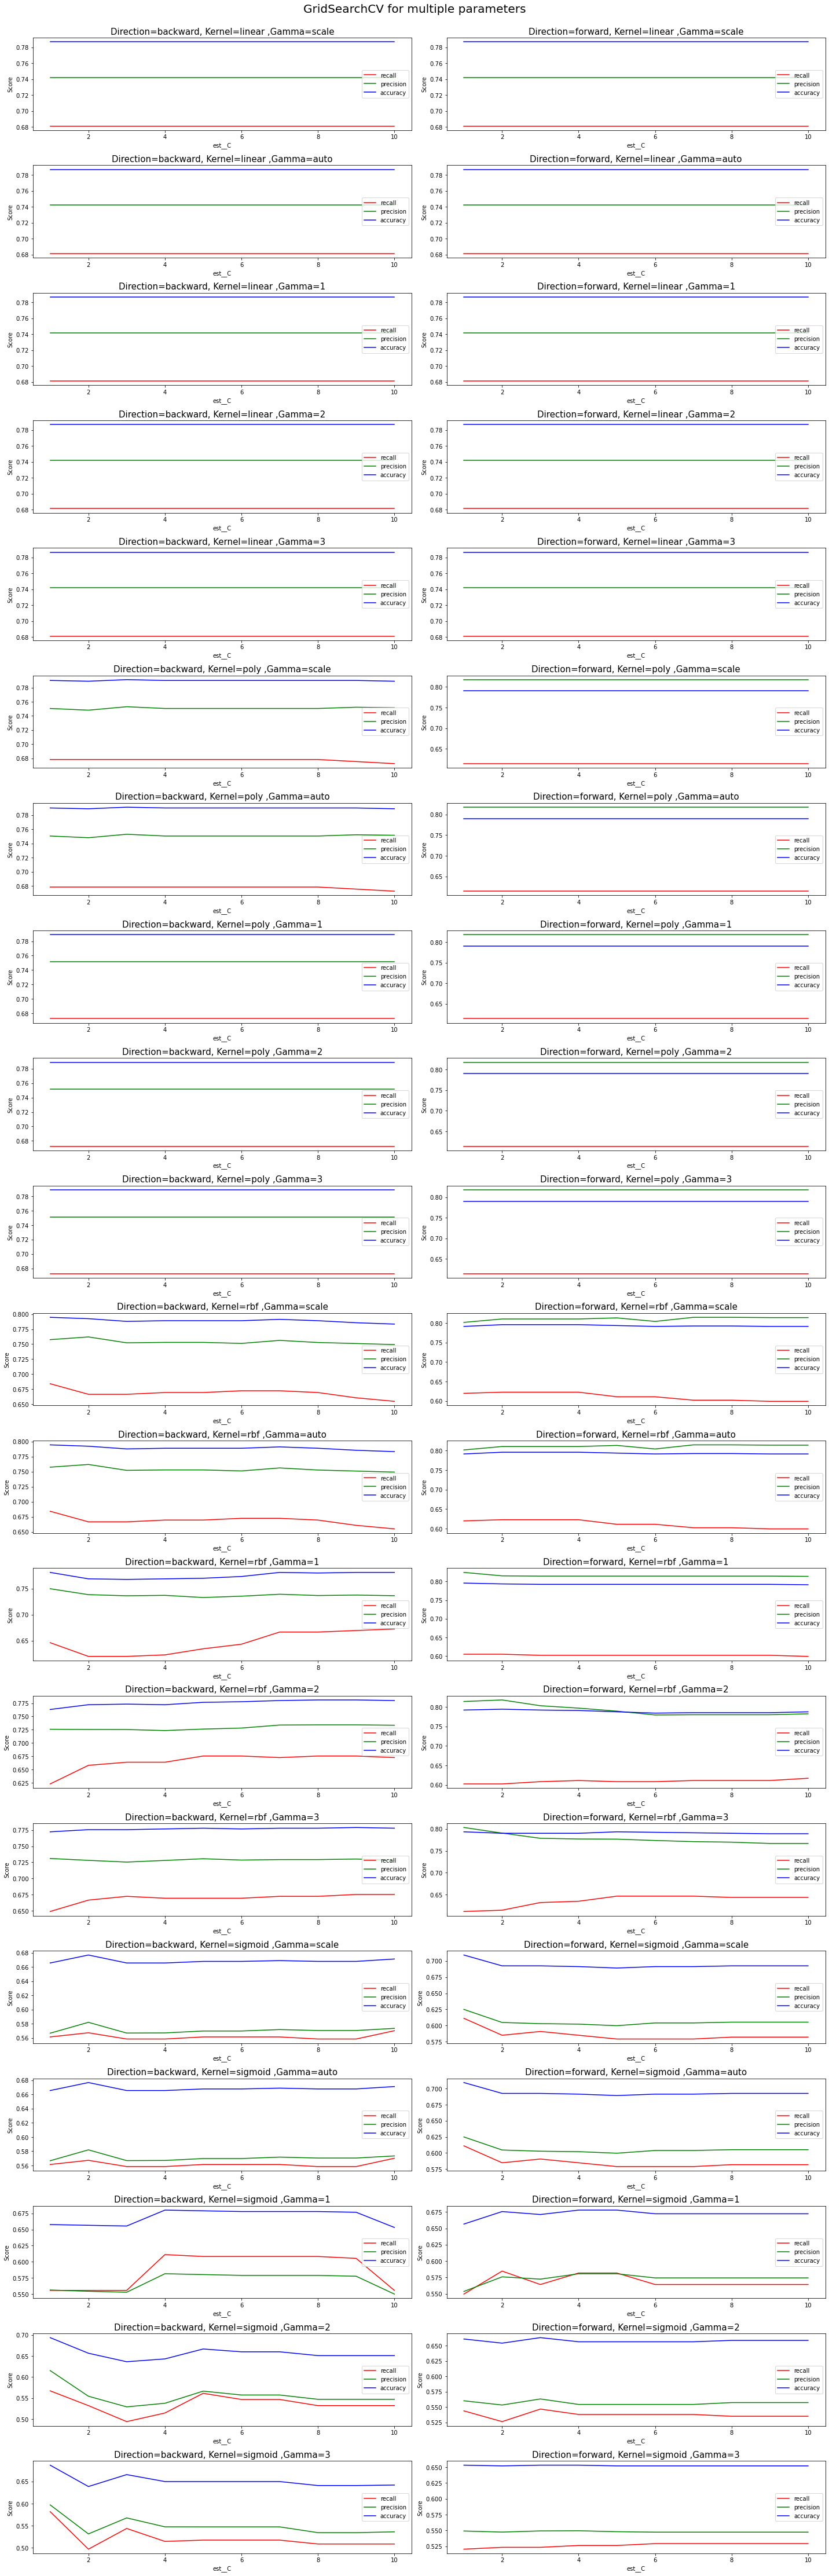

In [137]:
fig, ax = plt.subplots(len(params['est__gamma']) * len(params['est__kernel']), len(params['selector__direction']), figsize=(20,65))

gamma_lenght = len(params['est__gamma'])

for d, direction in enumerate(params['selector__direction']):    
    
    for i, kernel in enumerate(params['est__kernel']):        
        
        for j, gamma in enumerate(params['est__gamma']):
            for metric, color in zip(['recall', 'precision', 'accuracy'], ['r', 'g', 'b']):
                
                df_target = df_grid.query(f"param_est__gamma=='{gamma}' and param_est__kernel=='{kernel}' and param_selector__direction=='{direction}'")
                ax[i*gamma_lenght+j][d].plot(df_target['param_est__C'].astype(int), df_target[f'mean_test_{metric}'], c=color, label=metric)

                ax[i*gamma_lenght+j][d].set_title(f"Direction={direction}, Kernel={kernel} ,Gamma={gamma}", fontsize=15)
                ax[i*gamma_lenght+j][d].set_ylabel("Score")
                ax[i*gamma_lenght+j][d].set_xlabel("est__C")
                ax[i*gamma_lenght+j][d].legend(loc='center right')  

fig.suptitle(f"GridSearchCV for multiple parameters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
fig.show()

In [121]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'est__C': 1, 'est__gamma': 1, 'est__kernel': 'rbf', 'selector__direction': 'forward'}
0.7957351290684623
Pipeline(steps=[('scalar', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(estimator=SVC(C=1, gamma=1,
                                                         kernel='linear',
                                                         random_state=42),
                                           n_jobs=-1)),
                ('est', SVC(C=1, gamma=1, random_state=42))])
